<a href="https://colab.research.google.com/github/sudharson-c/ocv-projects/blob/main/License_Plate_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# Install required libraries
!pip install easyocr
!apt-get install -y tesseract-ocr
!pip install opencv-python-headless matplotlib

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 54 not upgraded.


In [15]:
# Import required libraries
import cv2
import pytesseract
import matplotlib.pyplot as plt
import easyocr
import numpy as np



In [17]:
# Set Tesseract path
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'  # Default path in Colab


In [34]:
# Function to preprocess the image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found.")
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 200)
    return image, edges

# Function to detect the license plate region
def find_license_plate(image, edges):
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)
        if len(approx) == 4:  # Look for rectangles
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = w / h
            if 2 < aspect_ratio < 5 and w > 100 and h > 30:  # Aspect ratio and size checks
                return image[y:y+h, x:x+w]
    return None

# Function to recognize text using Tesseract
def recognize_text_tesseract(license_plate):
    if license_plate is not None:
        gray_plate = cv2.cvtColor(license_plate, cv2.COLOR_BGR2GRAY)
        _, threshold_plate = cv2.threshold(gray_plate, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        text = pytesseract.image_to_string(threshold_plate, config="--psm 8 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789")
        return text.strip()
    return "License plate not detected."

# Function to recognize text using EasyOCR
def recognize_text_easyocr(license_plate):
    if license_plate is None:
        return "License plate not detected."
    reader = easyocr.Reader(['en'])
    results = reader.readtext(cv2.cvtColor(license_plate, cv2.COLOR_BGR2RGB))
    return results[0][-2] if results else "License plate not detected."

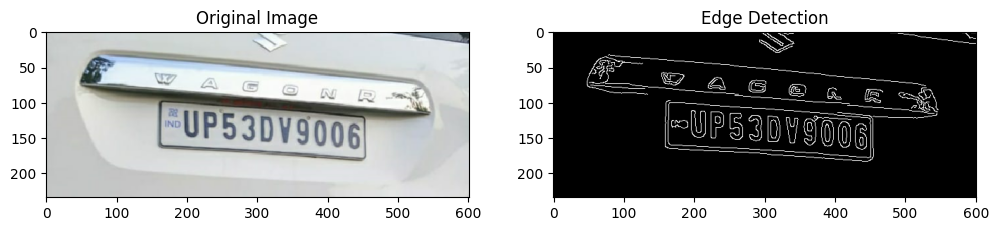

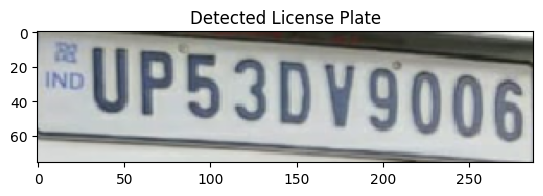

Tesseract OCR Result: UPS30V9006
EasyOCR Result: IND


In [38]:

# Main function
def main(image_path):
    image, edges = preprocess_image(image_path)

    # Display original image and edges
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 2, 2)
    plt.title("Edge Detection")
    plt.imshow(edges, cmap='gray')
    plt.show()

    # Detect license plate
    license_plate = find_license_plate(image, edges)
    if license_plate is not None:
        plt.title("Detected License Plate")
        plt.imshow(cv2.cvtColor(license_plate, cv2.COLOR_BGR2RGB))
        plt.show()

        # Recognize text
        text_tesseract = recognize_text_tesseract(license_plate)
        print("Tesseract OCR Result:", text_tesseract)

        text_easyocr = recognize_text_easyocr(license_plate)
        print("EasyOCR Result:", text_easyocr)
    else:
        print("License plate not detected.")

# Upload an image
from google.colab import files
# uploaded = files.upload()

# Run the main function
# uploaded_image_path = list(uploaded.keys())[0]
main("/content/image2.png")